TO DO

(1) Do we systematically throw out parts of the cloud which have low Pfrac by using the 3-sigma cutoff? 

(2) Do binned statistics to create Pfrac as a function of column density (whole cloud as well as Ridge and sub-filaments.Reference: Figure 15, Planck 2019

(3) Refer to Fissel 2016 PvsN or PvsS as a function of temperature for heated sightlines to understand why similar column density sightlines in Ridge versus sub-filaments are different.

 Explore NvsT to find outliers and see where they lie in the map. BLAST did not have sufficient resolution to probe the highest column density and SOFIA might be able to address that. Juan referred to Planck XII figure 13 that conducted a similar analysis.

TO DO 

(1) Concerning the binning, I think what we should have is the scatter like you had before but with now with a running means binned along the x axis. We should also show the scatter the data as error bars.

(2) Related to Pvs N, do you see a clear correlation between N & T for the ridge? We did see a clear correlation between P and N. So we should also check whether there is a correlation between P and T.  This would help in understanding if N is indeed important in determining P

Importing the required libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 18})
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
%matplotlib widget


Writing the required functions

In [3]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid
    
def lin_fit(x, a, b):
    return a + b*x

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def binning_data(array1,array2,delt):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
    plt.figure(figsize=(10,6))
    plt.scatter(levels_centres,binned_data)


def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return param

def remove_nan(array1,array2):
    selector = ~np.isnan(array1)
    array1_fil = array1[selector]
    array2_fil = array2[selector]

    selector = ~np.isnan(array2_fil)
    array1_fil = array1_fil[selector]
    array2_fil = array2_fil[selector]
    return array1_fil,array2_fil

def binning_datav1(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    plt.figure(figsize=(12,8))
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,c='k')

def binning_datav2(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    # plt.figure(figsize=(10,6))
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,c='k')

def binning_datav3(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    level_bins = np.linspace(np.amin(levels_centres),np.amax(levels_centres),10)
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    levels_centres = np.array(levels_centres)
    param, PS_param_cov = curve_fit(lin_fit, levels_centres, binned_data,sigma=error_bar)
    PS_FitFunc = lin_fit(level_bins,param[0],param[1])
    return param,level_bins,PS_FitFunc


Importing the fits files

Filename: ../FITS_file/new_fits/DR21_OTF_full_pipeline.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1406   (232, 302)   float64   
  1  ERROR I       1 ImageHDU        19   (232, 302)   float64   
  2  STOKES Q      1 ImageHDU        19   (232, 302)   float64   
  3  ERROR Q       1 ImageHDU        19   (232, 302)   float64   
  4  STOKES U      1 ImageHDU        19   (232, 302)   float64   
  5  ERROR U       1 ImageHDU        19   (232, 302)   float64   
  6  IMAGE MASK    1 ImageHDU        51   (232, 302)   float64   
  7  PERCENT POL    1 ImageHDU        19   (232, 302)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        19   (232, 302)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        19   (232, 302)   float64   
 10  POL ANGLE     1 ImageHDU        19   (232, 302)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        19   (232, 302)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        19   (232, 302)   f

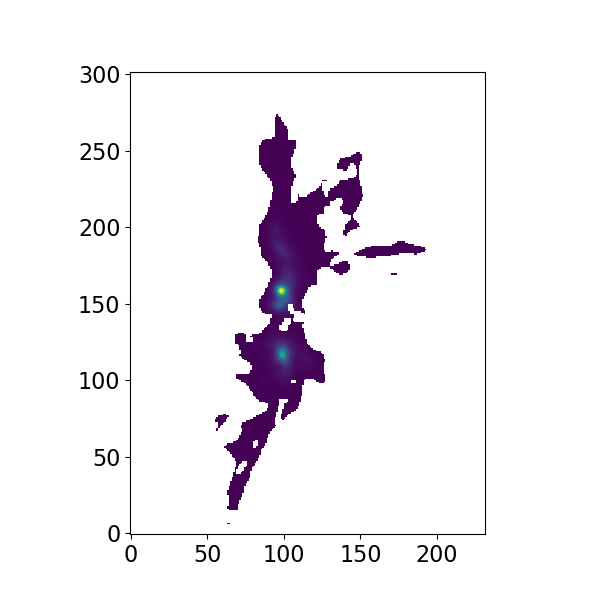

In [4]:
########## importing and testing the file
FITS1 = '../FITS_file/new_fits/DR21_OTF_full_pipeline.fits'
FITS2 = '../FITS_file/new_fits/DR21_full_NH2_Repr.fits'
FITS3 = '../FITS_file/new_fits/DR21_full_Tdust_Repr.fits'
FITS4 = '../FITS_file/new_fits/DR21_full_IRAC4_Repr.fits'
FITS5 = '../FITS_file/new_fits/DR21_full_Her250_Repr.fits'
hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
print(hdul.info())

MapStokesI = hdul[0]
MapStokesIError = hdul[1]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]



MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()



######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan



############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############ removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)



############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

plt.figure(figsize=(6,6))
# plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)
plt.imshow(BlankedMapStokesI.data,origin='lower')
plt.show()

# BlankedMapStokesI.writeto('test.fits')

Creating the angular dispersion map and debiasing it

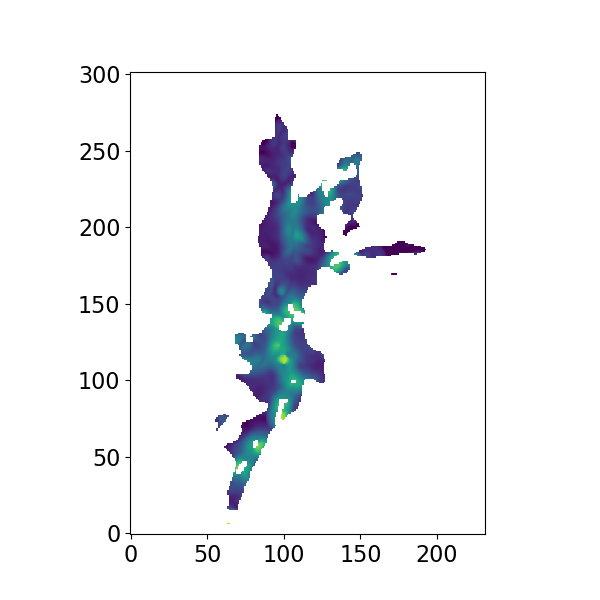

In [5]:
# set_delta = 0.5   # in arcminute
# S_map = BlankedMapPolAngle.copy()
# sigma_S_map = BlankedMapPolAngleError.copy()

# for i in range(RA_grid.shape[0]):
#     for j in range(RA_grid.shape[1]):

#         ##### seperation filter
#         seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
#         seperation_selector = (seperation.data<0.5*set_delta)
#         seperation.data[seperation_selector] = np.nan
#         seperation_selector = (seperation.data>1.5*set_delta)
#         seperation.data[seperation_selector] = np.nan
#         seperation_selector = (seperation.data >0)

#         ##### making the dispersion map
#         tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
#         tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
#         AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
#         S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
#         S_map.data[i,j] = S

#         ##### making the dispersion error map
#         sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
#         sigma_S_map.data[i,j] = sigma_S


# S_map_deb = S_map.copy()
# S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)

hdu = fits.open('../Internship-MIT/S_map.fits')[1]
plt.imshow(hdu.data,origin='lower')
plt.show()
S_map_deb = hdu

# FITS6 = 'Smap.fits'
# S_map_deb = fits.open(FITS6)[0]
# # print(S_map_deb.info())
# plt.imshow(S_map_deb.data,origin='lower')
# # plt.show()

Plotting fits files with aplpy

In [ ]:
# LogMapColumnDensity = MapColumndensity.copy()
# LogMapColumnDensity.data = np.log10(LogMapColumnDensity.data)

# plt.figure(figsize=(15,15))

# fig = plt.subplots(figsize=(15,15))
# scuba = aplpy.FITSFigure(S_map_deb)
# # plt.imshow(MapHer250.data,origin='lower',vmin = 0 , vmax = 250)
# scuba.ticks.set_xspacing(0.1) # number in degrees

# scuba.show_colorscale(cmap='default',vmin = 0,vmax = 55)

# scuba.ticks.show()
# scuba.ticks.show_x()
# scuba.ticks.show_y()
# # aplpy.Colorbar.show(location='right', width=0.2, pad=0.05, ticks=None,)
# scuba.add_colorbar(location='right', width=0.2, pad=0.15, ticks=None,axis_label_text= 'angle dispersion')
# # plt.tight_layout()
# plt.show()


: 

Saving data into csv files

In [ ]:
# DEC_array = DEC_grid.flatten()
# RA_array = RA_grid.flatten()
# StokesI_array = BlankedMapStokesI.data.flatten()
# S_array = S_map_deb.data.flatten()
# P_array = BlankedMapPol.data.flatten()
# nh2_array = BlankedMapColumnDensity.data.flatten()
# temperature_array = BlankedMapTemperature.data.flatten()
# PolAngleNonRotated_array = BlankedMapPolAngleNonRotated.data.flatten()
# micron8_array = BlankedMap8Mircon.data.flatten()
# df = pd.DataFrame({'RA': RA_array, 'DEC': DEC_array,'P':P_array, 'PolAng': PolAngleNonRotated_array ,'I': StokesI_array,'S':S_array,'ColumnDen':nh2_array,'Temperature':temperature_array,'8micron':micron8_array})
# df.to_csv('..\data\data_dr21.csv',sep=chr(44))

: 

whole region analysis

C : 11.38681070503585
s index : -0.367483720285361
nh2 index : -0.4598648234841688


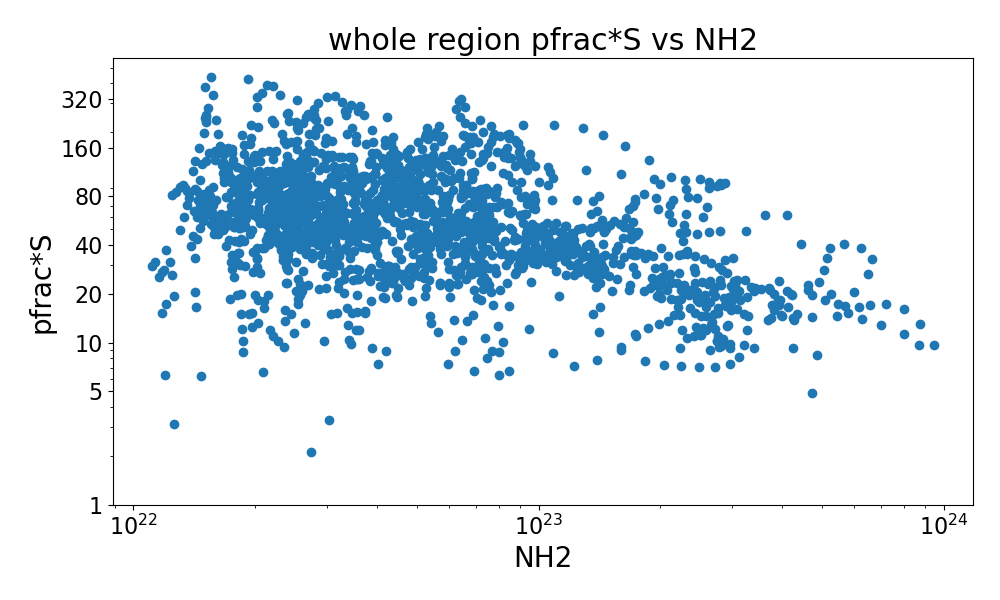

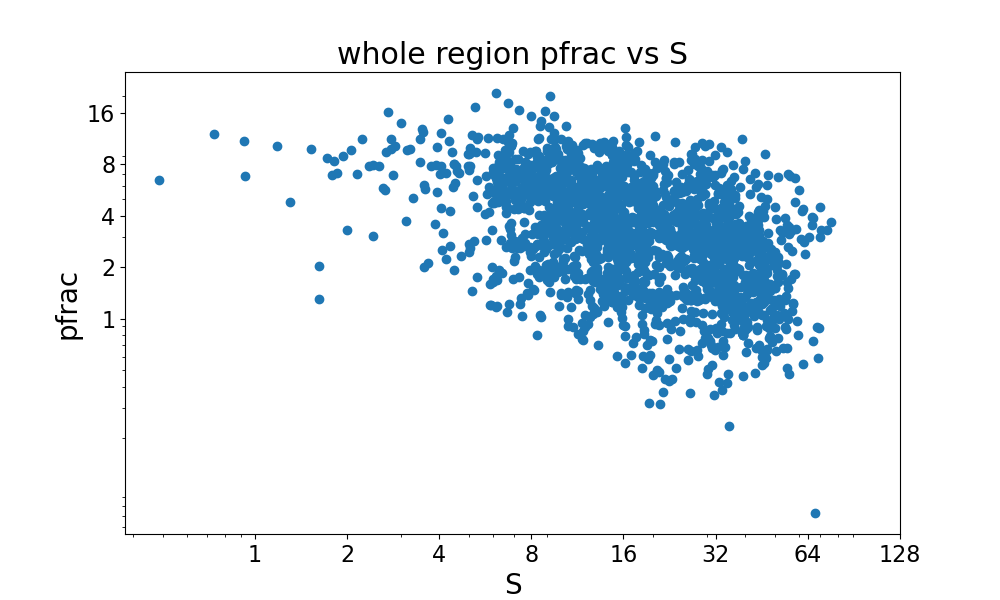

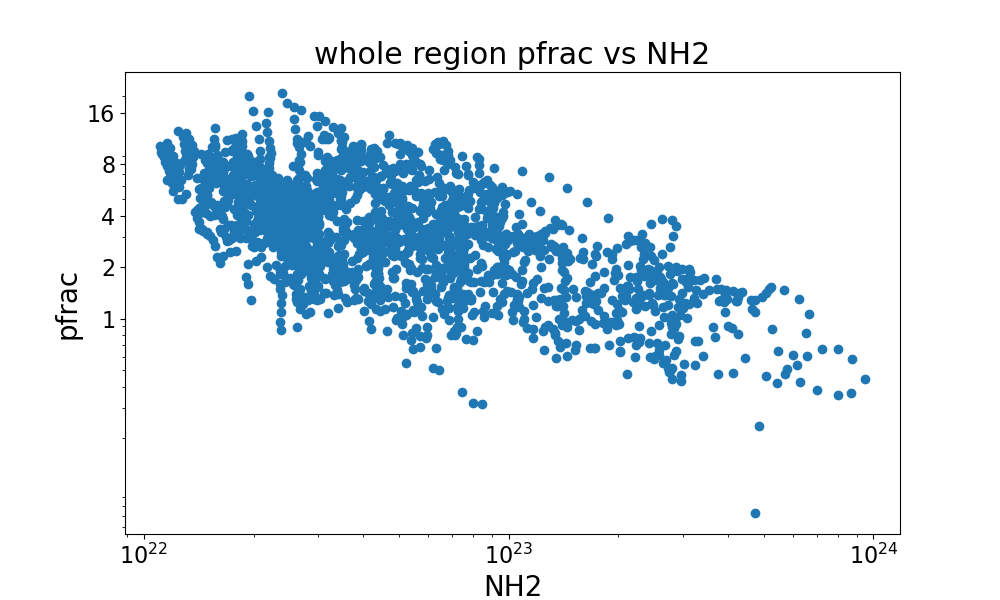

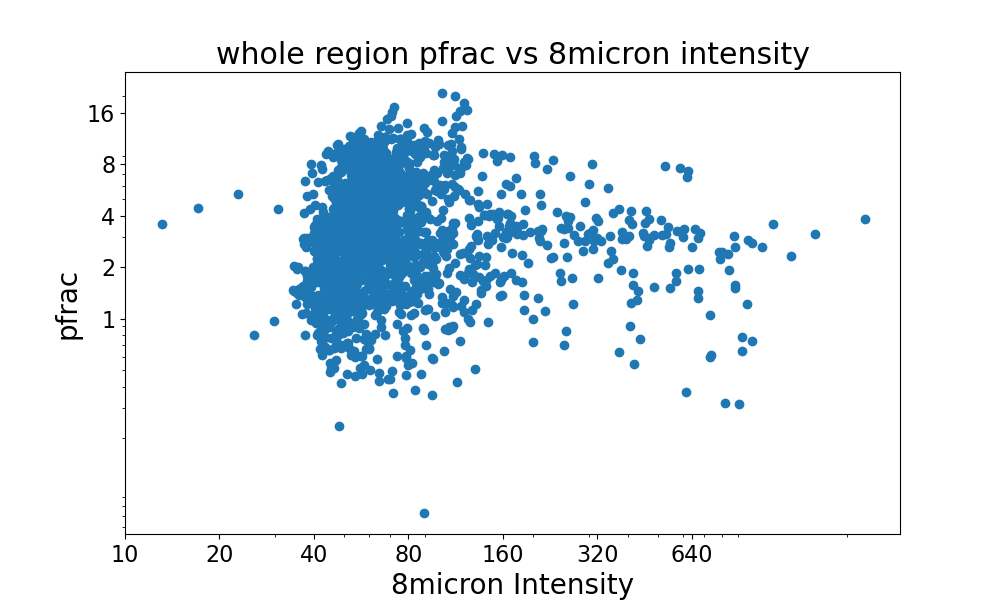

In [6]:
############### changing data to array
s_array = S_map_deb.data.flatten()
p_array = BlankedMapPol.data.flatten()
I_array = BlankedMapStokesI.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
micron8_array = BlankedMap8Mircon.data.flatten()

############# making the data independent
s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
I_array_ind = I_array.copy()
I_array_ind = I_array_ind[::4]
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
micron8_array_ind = micron8_array.copy()
micron8_array_ind = micron8_array_ind[::4]

########## taking log 10 of the data
log_s = np.log10(s_array_ind)
log_p = np.log10(p_array_ind)
log_I = np.log10(I_array_ind)
log_nh2 = np.log10(nh2_array_ind)
log_8micron = np.log10(micron8_array_ind)

######## making bins of the array for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)

############ fitting the data 
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

########### single parameter fitting
PS_param, PS_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc = lin_fit(s_bins,PS_param[0],PS_param[1])

PI_param, PI_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc = lin_fit(I_bins,PI_param[0],PI_param[1])

Pnh2_param, Pnh2_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc = lin_fit(nh2_bins,Pnh2_param[0],Pnh2_param[1])

########### Double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])


p0 = -0.2278, -0.8567, 2.
PSNH2_param_lower, PSNH2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSNH2_param_lower[0])
print('s index :',PSNH2_param_lower[1])
print('nh2 index :',PSNH2_param_lower[2])


################## plot absolute values
fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(s_array_ind,p_array_ind)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_param[1],C = PS_param[0],linebreak='\n')
# ax1.plot(10**s_bins,10**PS_FitFunc,'r',linewidth=3,label = label_temp)
ax1.set_title("whole region pfrac vs S")
ax1.set_ylabel('pfrac',fontdict={'fontsize':20})
ax1.set_xlabel('S',fontdict={'fontsize':20})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_yticks(2**np.array([0,1,2,3,4]))
ax1.set_xticks(2**np.array([0,1,2,3,4,5,6,7]))

# # fig = plt.subplots(figsize =(12, 8))
# # ax2 = plt.subplot(111)
# # ax2.scatter(log_I,log_p)
# # label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_param[1],C = PI_param[0],linebreak='\n')
# # ax2.plot(I_bins,PI_FitFunc,'r',linewidth=3,label = label_temp)
# # # ax2.set_title("whole region log p X log I")
# # ax2.set_ylabel('log p')
# # ax2.set_xlabel('log I')

fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(nh2_array_ind,p_array_ind)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# ax3.plot(10**nh2_bins,10**Pnh2_FitFunc,'r',linewidth=3,label = label_temp)
ax3.set_title("whole region pfrac vs NH2")
ax3.set_ylabel('pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('NH2',fontdict={'fontsize':20})
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax3.set_yticks(2**np.array([0,1,2,3,4]))

fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(micron8_array_ind,p_array_ind)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
ax4.set_title("whole region pfrac vs 8micron intensity")
ax4.set_ylabel('pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('8micron Intensity',fontdict={'fontsize':20})
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.set_yticks(2**np.array([0,1,2,3,4]))
ax4.set_xticks(np.array([10,20,40,80,160,320,640]))

fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(nh2_array_ind,p_array_ind*s_array_ind)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
ax5.set_title("whole region pfrac*S vs NH2")
ax5.set_ylabel('pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('NH2',fontdict={'fontsize':20})
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax5.set_yticks(np.array([1,5,10,20,40,80,160,320]))

# ax1.legend()
# ax3.legend()
plt.tight_layout()
plt.rcParams.update({'font.size': 19})
plt.show()

binned data analysis whole region 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\DELL\AppData\Local\Temp\ipykernel_13168\3099836720.py:16: RuntimeWarning: Mean of empty slice
  bin_centres.append(np.nanmean(sorted1[i*bin_size:i*bin_size+bin_size]))
C:\Users\DELL\AppData\Local\Temp\ipykernel_13168\3099836720.py:17: RuntimeWarning: Mean of empty slice
  data_binned.append(np.nanmean(sorted2[i*bin_size:i*bin_size+bin_size]))


KeyError: '[1394, 1381, 1368, 1382, 1353, 1283, 1304, 1284, 1369, 1245, 1749, 1305, 1264, 1322, 1762, 1367, 1775, 1244, 1263, 1337, 1282, 1303, 1321, 1227, 630, 1285, 1226, 1354, 1306, 749, 644, 1323, 1243, 1366, 1922, 658, 762, 672, 1262, 1654, 1338, 1630, 1667, 1242, 1281, 686, 1241, 774, 1680, 76, 1941, 819, 1302, 807, 493, 785, 796, 1320, 700, 1336, 74, 479, 43, 713, 465, 1951, 87, 1261, 451, 1693, 725, 438, 91, 426, 1878, 737, 1240, 1260, 40, 95, 1961, 1707, 750, 1280, 72, 1885, 1259, 591, 1720, 763, 1970, 1335, 182, 1891, 100, 187, 604, 1278, 1334, 37, 192, 1301, 830, 1299, 1318, 617, 1898, 1300, 1279, 1980, 775, 1319, 1734, 177, 105, 820, 631, 69, 1906, 786, 1988, 1979, 115, 645, 210, 34, 1106, 808, 1914, 2028, 172, 1952, 659, 797, 216, 1748, 1942, 110, 1923, 193, 224, 66, 1962, 99, 2001, 673, 167, 198, 2021, 2007, 31, 188, 161, 204, 155, 121, 2014, 1761, 211, 63, 116, 217, 148, 1971, 687, 225, 2054, 1618, 18, 128, 141, 135, 231, 183, 1096, 238, 245, 1805, 122, 162, 1629, 1865, 28, 1774, 1116, 104, 1796, 1858, 1786, 1981, 1823, 701, 714, 127, 1850, 726, 738, 1832, 178, 146, 60, 1841, 78, 1871, 751, 1607, 809, 2051, 494, 1653, 395, 109, 156, 134, 1995, 2035, 1877, 21, 764, 25, 480, 1884, 173, 405, 2002, 1556, 57, 1890, 80, 140, 2029, 114, 2022, 153, 2015, 2046, 2008, 2078, 133, 1897, 202, 1666, 1606, 1105, 1545, 415, 1905, 54, 1127, 466, 149, 24, 147, 1617, 427, 120, 168, 1596, 1913, 2077, 1628, 2041, 439, 51, 1534, 452, 425, 154, 22, 831, 2036, 1679, 2075, 2076, 2030, 592, 83, 126, 142, 48, 27, 1440, 2003, 1996, 1972, 208, 1982, 2023, 163, 2009, 2073, 2016, 253, 1921, 246, 19, 1692, 205, 261, 1963, 2063, 2071, 2065, 239, 605, 2061, 821, 212, 1586, 160, 2074, 832, 2059, 579, 16, 132, 2069, 46, 2067, 1953, 232, 1115, 218, 1139, 2057, 822, 199, 1652, 811, 226, 799, 30, 288, 157, 1930, 1943, 690, 674, 2055, 660, 618, 86, 44, 788, 646, 1706, 136, 14, 2072, 41, 2052, 437, 2042, 215, 632, 688, 2037, 139, 2031, 810, 194, 1940, 2024, 1924, 38, 33, 2070, 1665, 567, 1125, 1576, 777, 2017, 1915, 2066, 2064, 2068, 2062, 2060, 2058, 1152, 798, 84, 50, 12, 1907, 2056, 702, 765, 36, 88, 35, 776, 81, 2053, 189, 166, 787, 1899, 129, 752, 2010, 1886, 150, 250, 1719, 1892, 90, 92, 341, 1678, 1866, 1859, 145, 766, 2043, 1879, 32, 449, 1872, 739, 1126, 555, 221, 715, 2032, 1950, 2038, 1851, 450, 704, 96, 293, 1842, 53, 184, 1691, 10, 727, 1165, 29, 778, 39, 2025, 1833, 350, 789, 2004, 753, 179, 123, 1566, 800, 101, 1428, 812, 94, 543, 117, 1137, 740, 111, 174, 106, 676, 1733, 171, 1705, 26, 728, 1, 767, 56, 8, 2000, 267, 0, 3, 823, 277, 716, 1731, 1960, 152, 23, 11, 1997, 1994, 59, 1149, 169, 13, 164, 143, 1957, 703, 833, 1987, 464, 62, 158, 1824, 5, 273, 98, 229, 531, 7, 20, 9, 2, 717, 268, 42, 840, 262, 176, 1201, 65, 71, 1532, 68, 1189, 151, 15, 1138, 17, 519, 138, 1718, 1978, 144, 754, 349, 6, 1947, 254, 1747, 689, 1969, 2018, 70, 73, 1497, 131, 45, 2044, 103, 4, 181, 1555, 227, 219, 462, 247, 507, 675, 233, 1760, 847, 79, 67, 463, 1150, 1732, 661, 77, 213, 1983, 1704, 1509, 257, 240, 478, 359, 159, 108, 1745, 113, 119, 1162, 196, 741, 358, 125, 201, 186, 729, 647, 47, 82, 1804, 207, 1773, 1795, 1813, 214, 137, 75, 206, 191, 1785, 853, 1485, 1520, 272, 64, 2039, 1976, 235, 1822, 1746, 633, 918, 220, 1937, 1849, 298, 2011, 200, 1973, 1038, 1047, 367, 1840, 85, 282, 1831, 925, 1986, 859, 619, 1151, 1136, 165, 49, 195, 228, 61, 662, 89, 1759, 376, 55, 130, 1029, 52, 1544, 1298, 1964, 1163, 58, 1717, 1857, 1928, 492, 190, 1175, 234, 1954, 93, 368, 170, 2005, 1944, 1977, 124, 606, 1533, 260, 2050, 242, 477, 1934, 476, 185, 241, 1919, 1864, 932, 1772, 495, 1164, 315, 1925, 1967, 97, 1916, 385, 102, 1148, 1908, 118, 175, 265, 107, 1900, 309, 1317, 1521, 2033, 1277, 1508, 112, 303, 283, 180, 963, 1393, 248, 1496, 1187, 1484, 506, 1605, 1968, 699, 1405, 1522, 1473, 1893, 1664, 1784, 1296, 377, 1380, 1188, 394, 1474, 939, 1486, 1462, 593, 1416, 955, 1998, 1451, 648, 278, 255, 1730, 263, 287, 1365, 1258, 1776, 1510, 2045, 1771, 321, 269, 1427, 1794, 1439, 1911, 1887, 1498, 1616, 1161, 1037, 491, 249, 274, 947, 1958, 1349, 481, 1395, 1200, 404, 685, 1959, 1297, 308, 518, 620, 634, 386, 1275, 2026, 1880, 414, 580, 1803, 607, 424, 1213, 1333, 271, 436, 1992, 1867, 1406, 1949, 1046, 1212, 992, 1860, 1677, 396, 1276, 1939, 999, 1225, 1257, 1239, 1174, 1852, 1783, 448, 1256, 1224, 327, 712, 316, 1763, 467, 761, 1863, 490, 671, 1903, 2040, 1055, 406, 1339, 1238, 1948, 416, 1463, 530, 1316, 1383, 258, 1627, 1063, 1744, 568, 292, 266, 594, 748, 1870, 256, 1006, 314, 894, 1984, 1014, 2019, 1883, 1876, 1855, 428, 1843, 1056, 542, 505, 1812, 453, 985, 1071, 461, 1417, 1295, 440, 1186, 657, 1974, 554, 1079, 1370, 1543, 1554, 1531, 1565, 1938, 475, 2034, 1834, 1355, 1519, 1087, 1507, 566, 1452, 736, 1495, 1690, 1575, 1274, 2012, 297, 1965, 334, 643, 1483, 1929, 1585, 1429, 1472, 1064, 1821, 1199, 320, 629, 556, 899, 1595, 698, 1793, 1825, 1917, 1461, 1909, 578, 1255, 1920, 2027, 1095, 616, 1438, 1901, 489, 276, 1926, 1846, 1426, 1450, 264, 1955, 1750, 1441, 1894, 1935, 1124, 1639, 1415, 1881, 1114, 1868, 322, 1104, 590, 1888, 1837, 1237, 1604, 1211, 718, 1861, 1945, 504, 603, 1404, 1912, 1830, 2006, 2020, 1853, 1392, 1190, 517, 1223, 544, 1135, 730, 302, 1379, 326, 1072, 1542, 790, 1854, 1904, 1844, 801, 1530, 742, 1553, 1862, 905, 304, 342, 1845, 1364, 1869, 299, 2013, 1839, 1896, 1518, 684, 1875, 270, 1739, 779, 1564, 1889, 1882, 1895, 1999, 1615, 1147, 1802, 1506, 768, 755, 1735, 1836, 275, 1348, 1902, 1910, 532, 1574, 1918, 294, 724, 310, 813, 1927, 1703, 1494, 503, 1770, 1828, 279, 1725, 333, 1993, 1936, 281, 1651, 581, 1946, 289, 978, 1985, 1202, 1848, 1956, 1482, 284, 259, 1975, 1117, 1712, 1806, 1835, 1332, 1160, 1827, 328, 1594, 251, 824, 529, 1966, 317, 670, 1471, 516, 912, 340, 841, 1107, 307, 1603, 1626, 848, 1721, 834, 1080, 1460, 351, 1577, 1856, 1811, 520, 1686, 1614, 854, 1587, 1315, 348, 705, 1173, 1449, 1529, 1128, 1625, 1673, 1541, 1819, 1097, 1797, 1660, 919, 357, 323, 1648, 1624, 515, 1517, 1013, 1636, 1782, 1820, 1088, 1552, 1818, 1214, 860, 1613, 711, 286, 1826, 829, 1716, 1663, 1437, 1273, 971, 1021, 1563, 1637, 1254, 541, 1829, 1602, 1236, 1185, 818, 366, 1638, 1708, 865, 1573, 335, 1767, 1505, 1222, 1593, 926, 839, 1228, 313, 656, 1210, 508, 1838, 1425, 1810, 806, 1028, 1847, 360, 329, 375, 870, 1140, 1198, 933, 569, 1649, 1048, 1414, 528, 280, 1792, 1493, 527, 1801, 291, 964, 1246, 1787, 1685, 795, 846, 875, 384, 1817, 940, 880, 1790, 1808, 1036, 883, 1809, 784, 948, 956, 697, 1403, 337, 553, 1754, 330, 252, 336, 1694, 197, 773, 1481, 363, 345, 243, 852, 354, 393, 1729, 1661, 319, 324, 285, 691, 1391, 1672, 496, 760, 858, 318, 343, 1470, 296, 1045, 1650, 864, 311, 344, 325, 1676, 403, 1674, 1265, 1740, 1567, 305, 869, 369, 539, 1378, 1807, 565, 1743, 290, 642, 747, 814, 1659, 1681, 1459, 372, 1054, 890, 413, 1726, 300, 825, 683, 1070, 1687, 874, 332, 1062, 557, 1780, 1799, 1153, 353, 1713, 1800, 677, 802, 649, 301, 1777, 1286, 331, 423, 295, 1647, 482, 540, 835, 577, 1363, 338, 203, 1078, 735, 378, 663, 339, 1448, 621, 635, 352, 346, 551, 1635, 791, 312, 1307, 1662, 362, 236, 1166, 817, 842, 589, 1789, 827, 347, 828, 1086, 1689, 1798, 306, 435, 879, 1347, 805, 1324, 723, 837, 669, 895, 355, 816, 838, 849, 1039, 545, 1768, 1623, 628, 356, 602, 387, 844, 244, 1436, 1557, 371, 1791, 381, 836, 780, 608, 1094, 1178, 1764, 1779, 468, 1331, 1340, 843, 850, 804, 845, 615, 447, 563, 365, 710, 855, 209, 1668, 1314, 361, 380, 1612, 851, 826, 1030, 460, 1781, 857, 1022, 794, 1103, 793, 1015, 1766, 1424, 1191, 1272, 552, 1755, 1253, 863, 533, 397, 1675, 595, 861, 1788, 696, 222, 1601, 1702, 389, 655, 1134, 900, 1113, 454, 575, 1146, 1753, 1007, 1123, 1221, 815, 374, 1356, 1751, 1546, 1540, 1738, 474, 856, 1592, 1769, 1715, 1413, 1724, 587, 1159, 1528, 682, 370, 1209, 1711, 769, 1551, 502, 417, 1697, 399, 429, 1684, 1671, 488, 868, 600, 582, 1688, 407, 1197, 1741, 866, 1728, 613, 626, 1516, 1562, 640, 441, 1184, 521, 1172, 564, 654, 373, 1402, 668, 641, 783, 1572, 237, 803, 409, 1701, 1390, 570, 1658, 1742, 1504, 1203, 390, 1377, 1736, 1778, 782, 514, 871, 576, 1371, 1714, 1727, 558, 627, 1535, 873, 906, 379, 1655, 862, 1000, 1492, 1362, 509, 383, 904, 792, 756, 614, 588, 1523, 223, 876, 1646, 1765, 382, 419, 1722, 1511, 526, 1480, 601, 772, 878, 388, 734, 759, 746, 1346, 1499, 946, 867, 1752, 781, 911, 497, 546, 230, 954, 881, 1384, 1215, 743, 400, 722, 1634, 538, 1469, 392, 398, 1643, 1709, 938, 431, 1737, 917, 1073, 1330, 550, 884, 1396, 962, 408, 931, 770, 1723, 970, 924, 483, 872, 1622, 1458, 1005, 998, 709, 1407, 1710, 771, 1418, 534, 1012, 562, 418, 1611, 391, 1430, 1313, 402, 1696, 1487, 586, 991, 410, 1020, 443, 574, 1229, 1600, 1695, 430, 977, 984, 442, 1065, 1631, 1447, 1442, 455, 1683, 1252, 469, 599, 1271, 1591, 993, 625, 913, 639, 695, 891, 612, 1027, 456, 1670, 1453, 1475, 1081, 1581, 522, 877, 1464, 1571, 1657, 1435, 470, 412, 420, 1515, 1035, 1220, 1682, 1527, 401, 1619, 1561, 896, 757, 653, 1539, 510, 681, 1503, 1550, 1044, 882, 1247, 1645, 667, 758, 484, 1423, 1208, 1053, 1491, 731, 1089, 986, 498, 1057, 432, 1669, 1196, 1608, 1129, 1633, 885, 1412, 411, 434, 1158, 1183, 1171, 979, 1479, 1145, 957, 920, 1108, 965, 1141, 1098, 972, 1597, 1266, 1069, 1621, 1656, 1401, 889, 444, 446, 1133, 1077, 888, 421, 1610, 745, 949, 1085, 1154, 744, 1122, 1389, 1644, 1599, 1457, 1588, 910, 459, 893, 457, 1590, 1093, 1446, 535, 1049, 1167, 719, 1580, 1434, 1102, 433, 1376, 1287, 523, 1179, 1112, 941, 1216, 547, 901, 1192, 1204, 927, 511, 1361, 892, 1570, 733, 1632, 471, 934, 473, 898, 499, 1578, 485, 1345, 445, 1422, 487, 1560, 916, 501, 1329, 1620, 706, 1568, 1230, 732, 1308, 513, 458, 525, 1549, 721, 537, 472, 1411, 549, 1312, 1609, 536, 524, 1502, 897, 486, 692, 923, 1490, 512, 903, 559, 1040, 561, 1325, 500, 1558, 1538, 1514, 678, 1291, 930, 1248, 1598, 664, 1341, 708, 1400, 907, 1478, 1547, 720, 1589, 573, 1270, 1219, 571, 1233, 1207, 1357, 937, 1251, 548, 1579, 650, 902, 1388, 1267, 1195, 1569, 1372, 1182, 611, 909, 598, 694, 1536, 1375, 1170, 583, 585, 1385, 1559, 1360, 1397, 636, 1456, 596, 1031, 1157, 1288, 1512, 609, 622, 624, 1344, 1019, 1419, 707, 1011, 1445, 1500, 1026, 680, 1144, 1431, 1548, 1034, 1488, 1433, 1328, 1443, 908, 1043, 1465, 1476, 1052, 1454, 1132, 914, 1004, 638, 1309, 1249, 953, 1537, 1231, 1082, 666, 1217, 1421, 1121, 1268, 1205, 1311, 1068, 693, 1090, 961, 997, 652, 1023, 1074, 1193, 1289, 1180, 1290, 1168, 1326, 1269, 1111, 1250, 969, 994, 1076, 1513, 1310, 1399, 1232, 679, 1066, 1501, 990, 1001, 976, 1489, 1155, 560, 1218, 1477, 1101, 983, 665, 1327, 1084, 921, 1387, 1206, 1343, 1016, 1008, 1342, 1455, 1092, 1099, 1359, 651, 1374, 1142, 1444, 1194, 1058, 1420, 1358, 1432, 1398, 1373, 915, 637, 1386, 1181, 928, 1130, 1169, 987, 1109, 1156, 623, 935, 1143, 572, 1051, 1131, 1059, 1042, 1050, 950, 1120, 1067, 942, 610, 922, 1110, 958, 1033, 980, 1075, 1083, 1091, 1100, 597, 1025, 1041, 584, 966, 973, 1018, 1010, 929, 996, 1032, 952, 1024, 989, 936, 1017, 960, 943, 982, 1009, 968, 951, 975, 959, 995, 967, 988, 974, 981] not in index'

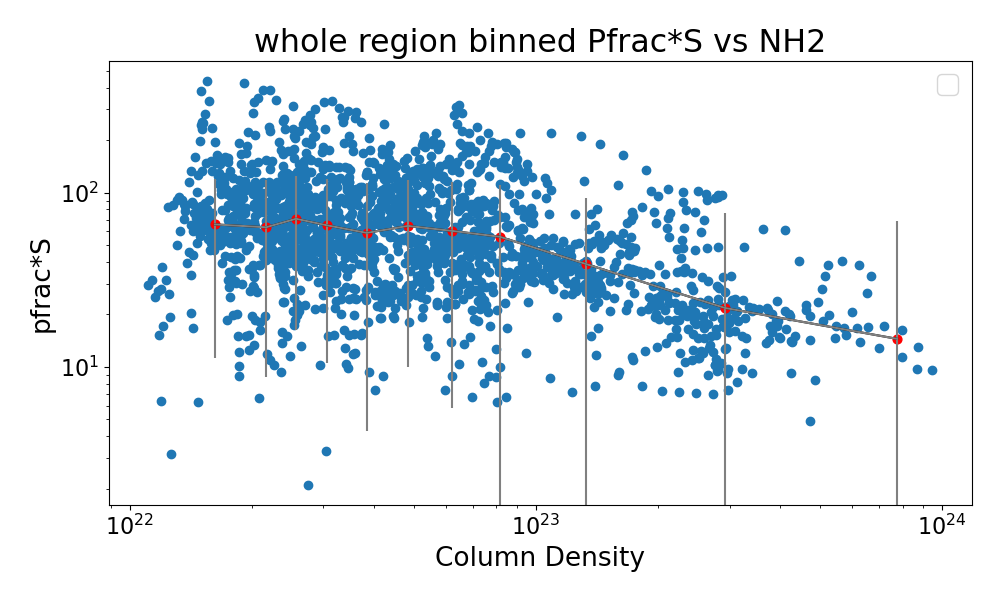

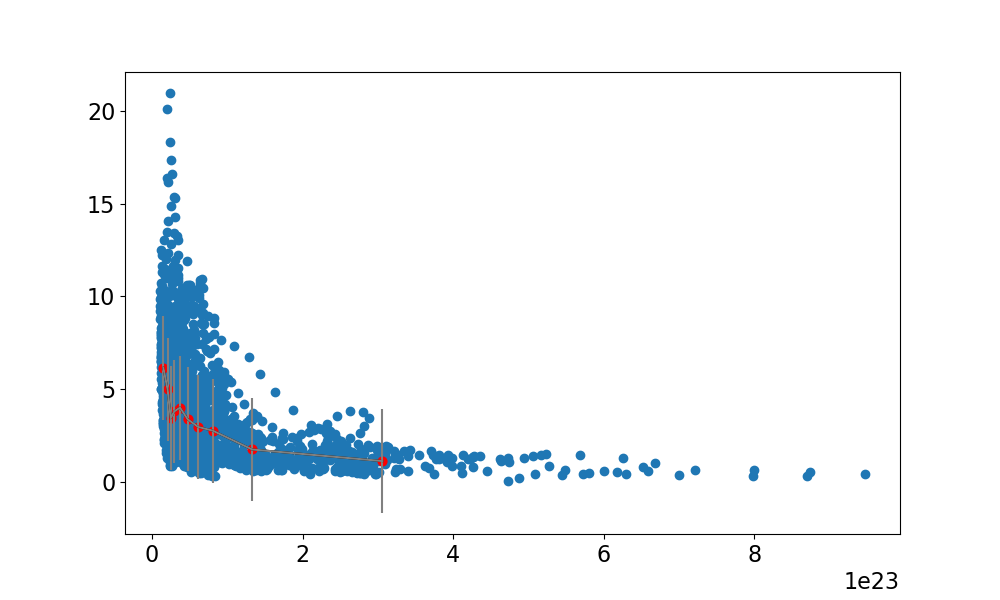

In [33]:
def lin_fit(x, a, b):
    return a + b*x

def binning_equal(array1,array2,bins):
    filtered1,filtered2 = remove_nan(array1,array2)
    def sortlinked(array1,array2):
        sort = np.argsort(array1)
        return array1[sort],array2[sort]
    bin_centres = []
    data_binned = []
    error_bar = []
    sorted1,sorted2 = sortlinked(filtered1,filtered2)
    bin_size = int((sorted2.shape[0])/bins)
    
    for i in range(0,bins+1):
        bin_centres.append(np.nanmean(sorted1[i*bin_size:i*bin_size+bin_size]))
        data_binned.append(np.nanmean(sorted2[i*bin_size:i*bin_size+bin_size]))
        error_bar.append(np.nanstd(10**sorted2))
    bin_centres = np.array(bin_centres)
    data_binned = np.array(data_binned)
    error_bar = np.array(error_bar)
    plt.errorbar(10**bin_centres,10**data_binned,yerr=error_bar,c='grey')
    plt.scatter(10**bin_centres,10**data_binned,s = 40,c='r')
    plt.plot(10**bin_centres,10**data_binned,c='k')


def binning_equal_fits(array1,array2,bins):
    filtered1,filtered2 = remove_nan(array1,array2)
    def sortlinked(array1,array2):
        sort = np.argsort(array1)
        return array1[sort],array2[sort]
    bin_centres = []
    data_binned = []
    error_bar = []
    sorted1,sorted2 = sortlinked(filtered1,filtered2)
    bin_size = int((sorted2.shape[0])/bins)
    
    for i in range(0,bins+1):
        bin_centres.append(np.nanmean(sorted1[i*bin_size:i*bin_size+bin_size]))
        data_binned.append(np.nanmean(sorted2[i*bin_size:i*bin_size+bin_size]))
        error_bar.append(np.nanstd(10**sorted2))
    bin_centres = np.array(bin_centres)
    data_binned = np.array(data_binned)
    error_bar = np.array(error_bar)
    level_bins = np.linspace(np.amin(bin_centres),np.amax(bin_centres),10)
    param, PS_param_cov = curve_fit(lin_fit, bin_centres, data_binned,sigma=error_bar)
    PS_FitFunc = lin_fit(level_bins,param[0],param[1])
    return param,10**level_bins,10**PS_FitFunc


plt.figure(figsize=(10,6))
plt.scatter(nh2_array_ind,p_array_ind*s_array_ind)
binning_equal(np.log10(nh2_array_ind),np.log10(p_array_ind*s_array_ind),10)
param,x,y = binning_equal_fits(np.log10(nh2_array_ind),np.log10(p_array_ind*s_array_ind),10)
label_temp = r'log(p*S) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
# plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac*S vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Column Density')
plt.ylabel('pfrac*S')
plt.tight_layout()
plt.legend()


plt.figure(figsize=(10,6))
plt.scatter(nh2_array_ind,p_array_ind)
binning_equal(log_nh2,log_p,10)
param,x,y = binning_equal_fits(log_nh2,log_p,10)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(s_array_ind,p_array_ind)
binning_equal(log_s,log_p,20)
param,x,y = binning_equal_fits(log_s,log_p,10)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()



log_p = np.array(df_log['logp'])
log_8micron = np.array(df_log['log_8micron'])

plt.figure(figsize=(10,6))
plt.scatter(10**log_8micron,10**log_p)
binning_equal(log_8micron,log_p,20)
plt.title('whole region binned Pfrac vs 8micron')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('8micron')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()


Bootstrap error estimation of the whole region.

In [ ]:
s_whole_array = S_map_deb.data.flatten()
p_whole_array = BlankedMapPol.data.flatten()
nh2_whole_array = BlankedMapColumnDensity.data.flatten()


log_s = np.log(s_whole_array)
log_p = np.log(p_whole_array)
log_nh2 = np.log(nh2_whole_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,1000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))


: 

Dividing the whole region into sub-regions

In [ ]:
def line_1(x, y):
    top_x = 309.9258719
    top_y = 42.4556451
    bottom_x = 309.7452960
    bottom_y =   42.4556451
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_2(x, y):
    top_x = 309.7838598
    top_y = 42.4569364
    bottom_x = 309.7792727
    bottom_y =  42.3127837
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_3(x, y):
    top_x = 309.7468561
    top_y = 42.4529922
    bottom_x = 309.7507272
    bottom_y =  42.4299500
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_4(x, y):
    top_x = 309.7507272
    top_y = 42.4305231
    bottom_x = 309.7108001
    bottom_y =  42.4094674
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_5(x, y):
    top_x = 309.7108001
    top_y = 42.4094674
    bottom_x = 309.699191
    bottom_y =  42.3710874
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

I_ridge_plus_fill_right= BlankedMapStokesI.copy()
p_ridge_plus_fill_right = BlankedMapPol.copy()
s_ridge_plus_fill_right = S_map_deb.copy()
nh2_ridge_plus_fill_right = BlankedMapColumnDensity.copy()
micron8_ridge_plus_fill_right = BlankedMap8Mircon.copy()
temp_ridge_plus_fill_right = BlankedMapTemperature.copy()

I_outflow = BlankedMapStokesI.copy()
p_outflow = BlankedMapPol.copy()
s_outflow = S_map_deb.copy()
nh2_outflow = BlankedMapColumnDensity.copy()
micron8_outflow = BlankedMap8Mircon.copy()
temp_outflow = BlankedMapTemperature.copy()


selector = (line_1(RA_grid,DEC_grid)<0)*(line_2(RA_grid,DEC_grid)<0)
I_ridge_plus_fill_right.data[selector] = np.nan
p_ridge_plus_fill_right.data[selector] = np.nan
s_ridge_plus_fill_right.data[selector] = np.nan
nh2_ridge_plus_fill_right.data[selector] = np.nan
micron8_ridge_plus_fill_right.data[selector] = np.nan
temp_ridge_plus_fill_right.data[selector] = np.nan

selector = ~selector
I_outflow.data[selector] = np.nan
p_outflow.data[selector] = np.nan
s_outflow.data[selector] = np.nan
nh2_outflow.data[selector] = np.nan
micron8_outflow.data[selector] = np.nan
temp_outflow.data[selector] = np.nan

I_fil_right = I_ridge_plus_fill_right.copy()
p_fil_right = p_ridge_plus_fill_right.copy()
s_fil_right = s_ridge_plus_fill_right.copy()
nh2_fil_right = nh2_ridge_plus_fill_right.copy()
micron8_fil_right = micron8_ridge_plus_fill_right.copy()
temp_fil_right = temp_ridge_plus_fill_right.copy()

I_ridge = I_ridge_plus_fill_right.copy()
p_ridge = p_ridge_plus_fill_right.copy()
s_ridge = s_ridge_plus_fill_right.copy()
nh2_ridge = nh2_ridge_plus_fill_right.copy()
micron8_ridge = micron8_ridge_plus_fill_right.copy()
temp_ridge = temp_ridge_plus_fill_right.copy()

selector = (line_1(RA_grid,DEC_grid)>0)+ (line_3(RA_grid,DEC_grid)<0)*(line_4(RA_grid,DEC_grid)>0) + (line_5(RA_grid,DEC_grid)>0)
  
I_ridge.data[selector] = np.nan
p_ridge.data[selector] = np.nan
s_ridge.data[selector] = np.nan
nh2_ridge.data[selector] = np.nan
micron8_ridge.data[selector] = np.nan
temp_ridge.data[selector] = np.nan

selector = ~selector
I_fil_right.data[selector] = np.nan
p_fil_right.data[selector] = np.nan
s_fil_right.data[selector] = np.nan
nh2_fil_right.data[selector] = np.nan
micron8_fil_right.data[selector] = np.nan
temp_fil_right.data[selector] = np.nan

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(BlankedMapStokesI.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region intensity')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(I_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('intensity ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(I_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('intensity outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(I_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('intensity right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(BlankedMapPol.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region pfrac')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(p_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('pfrac ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(p_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('pfrac outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(p_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('pfrac right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(S_map_deb.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region dispersion')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(s_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('dispersion ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(s_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('dispersion outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(s_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('dispersion right filament region')
# plt.tight_layout()
# plt.show()


# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(BlankedMapColumnDensity.data),origin='lower')
# ax1.set_title('whole region column')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(nh2_ridge.data),origin = 'lower')
# ax2.set_title('column density ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(nh2_outflow.data),origin = 'lower')
# ax3.set_title('column density outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(nh2_fil_right.data),origin = 'lower')
# ax4.set_title('column density right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(BlankedMap8Mircon.data),origin='lower')
# ax1.set_title('whole region 8micron map')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(micron8_ridge.data),origin = 'lower')
# ax2.set_title('8micron ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(micron8_outflow.data),origin = 'lower')
# ax3.set_title('8micron outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(micron8_fil_right.data),origin = 'lower')
# ax4.set_title('8micron right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(111)
# ax1.imshow(np.log(BlankedMapPol.data),origin='lower',vmin=0,vmax = 5)
# # ax1.set_title('whole region column')
# fig = plt.subplots(figsize =(15, 15))
# ax2 = plt.subplot(111)
# ax2.imshow(np.log(p_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# # ax2.set_title('column density ridge region')
# fig = plt.subplots(figsize =(15, 15))
# ax3 = plt.subplot(111)
# ax3.imshow(np.log(p_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# # ax3.set_title('column density outflow region')
# fig = plt.subplots(figsize =(15, 15))
# ax4 = plt.subplot(111)
# ax4.imshow(np.log(p_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# # ax4.set_title('column density right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(111)
# ax1.imshow(BlankedMapTemperature.data,origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region column')
# fig = plt.subplots(figsize =(15, 15))
# ax2 = plt.subplot(111)
# ax2.imshow(temp_ridge.data,origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('ridge region')
# fig = plt.subplots(figsize =(15, 15))
# ax3 = plt.subplot(111)
# ax3.imshow(temp_outflow.data,origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('outflow region')
# fig = plt.subplots(figsize =(15, 15))
# ax4 = plt.subplot(111)
# ax4.imshow(temp_fil_right.data,origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('column density right filament region')
# plt.tight_layout()
# plt.show()


: 

Analysis of the ridge region

In [ ]:
####### changing data to array
s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
I_ridge_array = I_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()
micron8_ridge_array = micron8_ridge.data.flatten()

######## making the data points independent
s_ridge_array_ind = s_ridge_array.copy()
s_ridge_array_ind = s_ridge_array_ind[::4]
p_ridge_array_ind = p_ridge_array.copy()
p_ridge_array_ind = p_ridge_array_ind[::4]
I_ridge_array_ind = I_ridge_array.copy()
I_ridge_array_ind = I_ridge_array_ind[::4]
nh2_ridge_array_ind = nh2_ridge_array.copy()
nh2_ridge_array_ind = nh2_ridge_array_ind[::4]
micron8_ridge_array_ind = micron8_ridge_array.copy()
micron8_ridge_array_ind = micron8_ridge_array_ind[::4]


######### taking log10 of the data
log_s = np.log10(s_ridge_array_ind)
log_p = np.log10(p_ridge_array_ind)
log_I = np.log10(I_ridge_array_ind)
log_nh2 = np.log10(nh2_ridge_array_ind)
log_8micron = np.log10(micron8_ridge_array_ind)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)


######## Fitting the data 
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

####### single parameter fitting
PS_ridge_param, PS_ridge_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_ridge = lin_fit(s_bins,PS_ridge_param[0],PS_ridge_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_ridge_param, PI_ridge_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_ridge = lin_fit(I_bins,PI_ridge_param[0],PI_ridge_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_ridge_param, Pnh2_ridge_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_ridge = lin_fit(nh2_bins,Pnh2_ridge_param[0],Pnh2_ridge_param[1])

###### Double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSnh2_param_lower, PSnh2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSnh2_param_lower[0])
print('s index :',PSnh2_param_lower[1])
print('nh2 index :',PSnh2_param_lower[2])


################## plot absolute values
fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(s_ridge_array_ind,p_ridge_array_ind)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param[1],C = PS_ridge_param[0],linebreak='\n')
# ax1.plot(10**s_bins,10**PS_FitFunc_ridge,'r',linewidth=3,label = label_temp)
ax1.set_title("ridge region pfrac vs S")
ax1.set_ylabel('pfrac',fontdict={'fontsize':20})
ax1.set_xlabel('S',fontdict={'fontsize':20})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_yticks(2**np.array([0,1,2,3,4]))
ax1.set_xticks(2**np.array([0,1,2,3,4,5,6,7]))


# # fig = plt.subplots(figsize =(10, 6))
# # ax2 = plt.subplot(111)
# # ax2.scatter(log_I,log_p)
# # label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_ridge_param[1],C = PI_ridge_param[0],linebreak='\n')
# # ax2.plot(I_bins,PI_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# # ax2.set_ylabel('log p')
# # ax2.set_xlabel('log I')

fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(nh2_ridge_array_ind,p_ridge_array_ind)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_ridge_param[1],C = Pnh2_ridge_param[0],linebreak='\n')
# ax3.plot(10**nh2_bins,10**Pnh2_FitFunc_ridge,'r',linewidth=3,label = label_temp)
ax3.set_title("ridge region pfrac vs NH2")
ax3.set_ylabel('pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('NH2',fontdict={'fontsize':20})
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
# ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:0d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax3.set_yticks(2**np.array([0,1,2,3,4]))
ax3.set_xticks(np.array([1e22,1e23,1e24]))

fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(micron8_ridge_array_ind,p_ridge_array_ind)
ax4.set_title("ridge region pfrac vs 8micron intensity")
ax4.set_ylabel('pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('8micron Intensity',fontdict={'fontsize':20})
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.set_yticks(2**np.array([0,1,2,3,4]))
ax4.set_xticks(np.array([10,20,40,80,160,320,640]))




fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(nh2_ridge_array_ind,p_ridge_array_ind*s_ridge_array_ind)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
ax5.set_title("ridge region pfrac*S vs NH2")
ax5.set_ylabel('pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('NH2',fontdict={'fontsize':20})
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax5.set_yticks(np.array([1,5,10,20,40,80,160,320]))
ax5.set_xticks(np.array([1e22,1e23,1e24]))


# ax1.legend()
# ax3.legend()
plt.tight_layout()
plt.rcParams.update({'font.size': 19})
plt.show()



: 

In [ ]:
# # ######### plotting the graphs
# fig = plt.subplots(figsize =(10, 6))
# ax1 = plt.subplot(111)
# ax1.scatter(log_s,log_p)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param[1],C = PS_ridge_param[0],linebreak='\n')
# ax1.plot(s_bins,PS_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# ax1.set_ylabel('log pfrac ',fontdict={'fontsize':20})
# ax1.set_xlabel('log S ',fontdict={'fontsize':20})


# # fig = plt.subplots(figsize =(10, 6))
# # ax2 = plt.subplot(111)
# # ax2.scatter(log_I,log_p)
# # label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_ridge_param[1],C = PI_ridge_param[0],linebreak='\n')
# # ax2.plot(I_bins,PI_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# # ax2.set_ylabel('log p')
# # ax2.set_xlabel('log I')


# fig = plt.subplots(figsize =(10, 6))
# ax3 = plt.subplot(111)
# ax3.scatter(log_nh2,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_ridge_param[1],C = Pnh2_ridge_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax3.set_xlabel('log Column Density',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax4 = plt.subplot(111)
# ax4.scatter(log_8micron,log_p)
# ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax5 = plt.subplot(111)
# ax5.scatter(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind*s_ridge_array_ind))
# # label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# # ax4.set_title("whole region log pfrac vs log 8micron intensity")
# ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
# ax5.set_xlabel('log Column density',fontdict={'fontsize':20})


# ax1.legend()
# ax3.legend()
# plt.tight_layout()
# plt.show()


: 

binned data analysis ridge region 

In [ ]:


plt.figure(figsize=(10,6))
binning_equal(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind*s_ridge_array_ind),10)
plt.scatter(nh2_ridge_array_ind,p_ridge_array_ind*s_ridge_array_ind)
plt.title('ridge region binned Pfrac*S vs NH2')
plt.xlabel('Column Density')
plt.ylabel('pfrac*S')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
binning_equal(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind),10)
plt.scatter(nh2_ridge_array_ind,p_ridge_array_ind)
param,x,y = binning_equal_fits(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind),10)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('ridge region binned Pfrac vs NH2')
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(s_ridge_array_ind,p_ridge_array_ind)
binning_equal(np.log10(s_ridge_array_ind),np.log10(p_ridge_array_ind),10)
param,x,y = binning_equal_fits(np.log10(s_ridge_array_ind),np.log10(p_ridge_array_ind),10)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('ridge region binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()

log_p = np.array(df_log['logp'])
log_8micron = np.array(df_log['log_8micron'])

plt.figure(figsize=(10,6))
plt.scatter(10**log_8micron,10**log_p)
binning_equal(log_8micron,log_p,20)
plt.title('whole region binned Pfrac vs 8micron')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('8micron')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()



: 

Bootstrap error Ridge region

In [ ]:
s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()

log_s = np.log(s_ridge_array)
log_p = np.log(p_ridge_array)
log_nh2 = np.log(nh2_ridge_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)

bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))

: 

Analysis of the Sub-filament region

In [ ]:
####### changing data to array
s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
I_fil_right_array = I_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()
micron8_fil_right_array = micron8_fil_right.data.flatten()


######## making the data points independent
s_fil_right_array_ind = s_fil_right_array.copy()
s_fil_right_array_ind = s_fil_right_array_ind[::4]
p_fil_right_array_ind = p_fil_right_array.copy()
p_fil_right_array_ind = p_fil_right_array_ind[::4]
I_fil_right_array_ind = I_fil_right_array.copy()
I_fil_right_array_ind = I_fil_right_array_ind[::4]
nh2_fil_right_array_ind = nh2_fil_right_array.copy()
nh2_fil_right_array_ind = nh2_fil_right_array_ind[::4]
micron8_fil_right_array_ind = micron8_fil_right_array.copy()
micron8_fil_right_array_ind = micron8_fil_right_array_ind[::4]


######## taking log10 of the data
log_s_fil = np.log10(s_fil_right_array_ind)
log_p_fil = np.log10(p_fil_right_array_ind)
log_I_fil = np.log10(I_fil_right_array_ind)
log_nh2_fil = np.log10(nh2_fil_right_array_ind)
log_8micron_fil = np.log10(micron8_fil_right_array_ind)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)


######## curve fitting
df_log = pd.DataFrame({'logp': log_p_fil,'logs':log_s_fil,'logI':log_I_fil,'lognh2':log_nh2_fil,'log_8micron_fil':log_8micron_fil})
df_log = df_log.dropna()

###### single parameter fitting
PS_fil_right_param, PS_fil_right_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_fil_right = lin_fit(s_bins,PS_fil_right_param[0],PS_fil_right_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_fil_right_param, PI_fil_right_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_fil_right = lin_fit(I_bins,PI_fil_right_param[0],PI_fil_right_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_fil_right_param, Pnh2_fil_right_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_fil_right = lin_fit(nh2_bins,Pnh2_fil_right_param[0],Pnh2_fil_right_param[1])


##### Double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSNH2_param_lower, PSNH2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSNH2_param_lower[0])
print('s index :',PSNH2_param_lower[1])
print('nh2 index :',PSNH2_param_lower[2])



################## plot absolute values

fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(s_fil_right_array_ind,p_fil_right_array_ind)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_fil_right_param[1],C = PS_fil_right_param[0],linebreak='\n')
# ax1.plot(10**s_bins,10**PS_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax1.set_title("sub-filament region pfrac vs S")
ax1.set_ylabel('pfrac',fontdict={'fontsize':20})
ax1.set_xlabel('S',fontdict={'fontsize':20})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_yticks(2**np.array([0,1,2,3,4]))
ax1.set_xticks(2**np.array([0,1,2,3,4,5,6,7]))



# fig = plt.subplots(figsize =(10, 6))
# ax2 = plt.subplot(111)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')


fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_fil_right_param[1],C = Pnh2_fil_right_param[0],linebreak='\n')
# ax3.plot(10**nh2_bins,10**Pnh2_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax3.set_title("sub-filament region pfrac vs NH2")
ax3.set_ylabel('pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('NH2',fontdict={'fontsize':20})
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
# ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:0d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax3.set_yticks(2**np.array([0,1,2,3,4]))
ax3.set_xticks(np.array([1e22,1e23,1e24]))

fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(micron8_fil_right_array_ind,p_fil_right_array_ind)
ax4.set_title("sub-filament region pfrac vs 8micron intensity")
ax4.set_ylabel('pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('8micron Intensity',fontdict={'fontsize':20})
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.set_yticks(2**np.array([0,1,2,3,4]))
ax4.set_xticks(np.array([10,20,40,80,160,320,640]))


fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind*s_fil_right_array_ind)
ax5.set_title("sub-filament region pfrac*S vs NH2")
ax5.set_ylabel('pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('NH2',fontdict={'fontsize':20})
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax5.set_yticks(np.array([1,5,10,20,40,80,160,320]))
ax5.set_xticks(np.array([1e22,1e23,1e24]))


# ax1.legend()
# ax3.legend()
plt.tight_layout()
plt.rcParams.update({'font.size': 19})
plt.show()



: 

In [ ]:
########## plotting the graphs
# fig = plt.subplots(figsize =(10, 6))
# ax1 = plt.subplot(111)
# ax1.scatter(log_s,log_p)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_fil_right_param[1],C = PS_fil_right_param[0],linebreak='\n')
# ax1.plot(s_bins,PS_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax1.set_ylabel('log pfrac ',fontdict={'fontsize':20})
# ax1.set_xlabel('log S ',fontdict={'fontsize':20})


# # # fig = plt.subplots(figsize =(10, 6))
# # # ax2 = plt.subplot(111)
# # # ax2.scatter(log_I,log_p)
# # # label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
# # # ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# # # ax2.set_ylabel('log p')
# # # ax2.set_xlabel('log I')


# fig = plt.subplots(figsize =(10, 6))
# ax3 = plt.subplot(111)
# ax3.scatter(log_nh2,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_fil_right_param[1],C = Pnh2_fil_right_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax3.set_xlabel('log Column Density',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax4 = plt.subplot(111)
# ax4.scatter(log_8micron,log_p)
# ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax5 = plt.subplot(111)
# ax5.scatter(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind*s_fil_right_array_ind))
# ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
# ax5.set_xlabel('log Column density',fontdict={'fontsize':20})



# ax1.legend()
# ax3.legend()
# plt.legend()
# plt.tight_layout()
# plt.show()


: 

binned data analysis sub-filament region 

In [ ]:
######## binning data
plt.figure(figsize=(10,6))
plt.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind*s_fil_right_array_ind)
binning_equal(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind*s_fil_right_array_ind),10)
plt.title('sub-filament region binned Pfrac*S vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Column Density')
plt.ylabel('pfrac*S')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind)
binning_equal(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
param,x,y = binning_equal_fits(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('sub-filament region binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.yticks([1e0,1e1])
plt.xticks(np.array([1e22,1e23,1e24]))
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(s_fil_right_array_ind,p_fil_right_array_ind)
binning_equal(np.log10(s_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
param,x,y = binning_equal_fits(np.log10(s_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('sub-filament region binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()

log_p = np.array(df_log['logp'])
log_8micron = np.array(df_log['log_8micron_fil'])

plt.figure(figsize=(10,6))
plt.scatter(10**log_8micron,10**log_p)
binning_equal(log_8micron,log_p,20)
plt.title('whole region binned Pfrac vs 8micron')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('8micron')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()

: 

Bootstrap error Sub-filament region.

In [ ]:
s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()

log_s = np.log(s_fil_right_array)
log_p = np.log(p_fil_right_array)
log_nh2 = np.log(nh2_fil_right_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)

bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))

: 

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind,c = 'royalblue',label = 'sub-filamnet')
plt.scatter(nh2_ridge_array_ind,p_ridge_array_ind,c='limegreen',label = 'ridge')
binning_datav2(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
binning_datav2(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind),10)
param,x,y = binning_datav3(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind),10)
label_temp = r'ridge{linebreak}log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'darkblue',linewidth = 2.5,label = label_temp)
param,x,y = binning_datav3(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
label_temp = r'sub-filament{linebreak}log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'k',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('NH2')
plt.ylabel('pfrac')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(s_fil_right_array_ind,p_fil_right_array_ind,c = 'royalblue',label = 'sub-filamnet')
plt.scatter(s_ridge_array_ind,p_ridge_array_ind,c='limegreen',label = 'ridge')
binning_datav2(np.log10(s_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
binning_datav2(np.log10(s_ridge_array_ind),np.log10(p_ridge_array_ind),10)
param,x,y = binning_datav3(np.log10(s_ridge_array_ind),np.log10(p_ridge_array_ind),10)
label_temp = r'ridge{linebreak}log(p) = C + $\alpha_s$log($S$){linebreak}  $\alpha_s$: {alpha_s:.4f} C: {C:.4f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'darkblue',linewidth = 2.5,label = label_temp)
param,x,y = binning_datav3(np.log10(s_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
label_temp = r'sub-filament{linebreak}log(p) = C + $\alpha_s$log($S$){linebreak}  $\alpha_s$: {alpha_s:.4f} C: {C:.4f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'k',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


: 

Analysis of the outflow region

In [ ]:
######## changing data to array
s_outflow_array = s_outflow.data.flatten()
p_outflow_array = p_outflow.data.flatten()
I_outflow_array = I_outflow.data.flatten()
nh2_outflow_array = nh2_outflow.data.flatten()
micron8_outflow_array = micron8_outflow.data.flatten()

s_outflow_array_ind = s_outflow_array.copy()
s_outflow_array_ind = s_outflow_array_ind[::4]
p_outflow_array_ind = p_outflow_array.copy()
p_outflow_array_ind = p_outflow_array_ind[::4]
I_outflow_array_ind = I_outflow_array.copy()
I_outflow_array_ind = I_outflow_array_ind[::4]
nh2_outflow_array_ind = nh2_outflow_array.copy()
nh2_outflow_array_ind = nh2_outflow_array_ind[::4]
micron8_outflow_array_ind = micron8_outflow_array.copy()
micron8_outflow_array_ind = micron8_outflow_array_ind[::4]


####### taking log10 of the data
log_s = np.log10(s_outflow_array)
log_p = np.log10(p_outflow_array)
log_I = np.log10(I_outflow_array)
log_nh2 = np.log10(nh2_outflow_array)
log_8micron = np.log10(micron8_outflow_array)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)


######## fitting the data
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

###### single parameter fitting
PS_outflow_param, PS_outflow_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_outflow = lin_fit(s_bins,PS_outflow_param[0],PS_outflow_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_outflow_param, PI_outflow_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_outflow = lin_fit(I_bins,PI_outflow_param[0],PI_outflow_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_outflow_param, Pnh2_outflow_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_outflow = lin_fit(nh2_bins,Pnh2_outflow_param[0],Pnh2_outflow_param[1])


###### double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSNH2_param_lower, PSNH2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSNH2_param_lower[0])
print('s index :',PSNH2_param_lower[1])
print('nh2 index :',PSNH2_param_lower[2])


######### plotting the graphs
fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_outflow_param[1],C = PS_outflow_param[0],linebreak='\n')
# ax1.plot(s_bins,PS_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax1.set_ylabel('log pfrac ',fontdict={'fontsize':20})
ax1.set_xlabel('log S ',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax2 = plt.subplot(111)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')


fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_outflow_param[1],C = Pnh2_outflow_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('log Column Density',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(log_8micron,log_p)
ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(np.log10(nh2_outflow_array_ind),np.log10(p_outflow_array_ind*s_outflow_array_ind))
ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('log Column density',fontdict={'fontsize':20})


ax1.legend()
ax3.legend()
plt.legend()
plt.tight_layout()
plt.show()


: 

Bootstrap error estimation of the outflow region

In [ ]:
s_outflow_array = s_outflow.data.flatten()
p_outlfow_array =p_outflow.data.flatten()
nh2_outflow_array = nh2_outflow.data.flatten()

log_s = np.log(s_outflow_array)
log_p = np.log(p_outlfow_array)
log_nh2 = np.log(nh2_outflow_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.mean(bootresult[:,1]))
print('error in alpha_nh2',np.mean(bootresult[:,2]))


: 

Temperature analysis whole region

In [ ]:
############### changing data to array
s_array = S_map_deb.data.flatten()
p_array = BlankedMapPol.data.flatten()
I_array = BlankedMapStokesI.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
micron8_array = BlankedMap8Mircon.data.flatten()
temp_array = BlankedMapTemperature.data.flatten()

############# making the data independent
s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
I_array_ind = I_array.copy()
I_array_ind = I_array_ind[::4]
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
micron8_array_ind = micron8_array.copy()
micron8_array_ind = micron8_array_ind[::4]
temp_array_ind = temp_array.copy()
temp_array_ind = temp_array_ind[::4]


########## taking log 10 of the data
log_s = np.log10(s_array_ind)
log_p = np.log10(p_array_ind)
log_I = np.log10(I_array_ind)
log_nh2 = np.log10(nh2_array_ind)
log_8micron = np.log10(micron8_array_ind)
log_temp = np.log10(temp_array_ind)

######## making bins of the array for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  
temp_min = np.nanmin(log_temp)
temp_max = np.nanmax(log_temp)

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)
temp_bins  = np.linspace(temp_min,temp_max,100)

# plt.figure(figsize =(10, 6))
# plt.scatter(nh2_array_ind,p_array_ind,c = temp_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('whole region log pfrac vs log Column Density')
# plt.ylabel('pfrac ',fontdict={'fontsize':20})
# plt.xlabel('Column Density ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(s_array_ind,p_array_ind,c = temp_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('whole region log pfrac vs log S')
# plt.ylabel('pfrac ',fontdict={'fontsize':20})
# plt.xlabel(' S ',fontdict={'fontsize':20})
# plt.xticks(2**np.array([0,1,2,3,4,5,6,7]))
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp,log_p,c = log_nh2,cmap='jet')
# plt.colorbar( label = 'log NH2')
# # plt.clim(18, 37.5) 
# plt.title('whole region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp,log_p)
# plt.title('whole region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

: 

In [ ]:
nh2_median = np.nanmedian(nh2_array_ind)
alpha_nh2 = -0.43
p_decol_nh2 = p_array_ind*((nh2_median/nh2_array_ind)**alpha_nh2)
log_p = np.log10(p_decol_nh2)
log_temp = np.log10(temp_array_ind)


plt.figure(figsize =(10, 6))
plt.scatter(log_temp,log_p)
plt.title('whole region log pfrac vs log Temperature')
plt.ylabel('log pfrac ',fontdict={'fontsize':20})
plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
plt.show()

: 

Temperature analysis of ridge region

In [ ]:
####### changing data to array
s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
I_ridge_array = I_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()
micron8_ridge_array = micron8_ridge.data.flatten()
temp_ridge_array = temp_ridge.data.flatten()

######## making the data points independent
s_ridge_array_ind = s_ridge_array.copy()
s_ridge_array_ind = s_ridge_array_ind[::4]
p_ridge_array_ind = p_ridge_array.copy()
p_ridge_array_ind = p_ridge_array_ind[::4]
I_ridge_array_ind = I_ridge_array.copy()
I_ridge_array_ind = I_ridge_array_ind[::4]
nh2_ridge_array_ind = nh2_ridge_array.copy()
nh2_ridge_array_ind = nh2_ridge_array_ind[::4]
micron8_ridge_array_ind = micron8_ridge_array.copy()
micron8_ridge_array_ind = micron8_ridge_array_ind[::4]
temp_ridge_array_ind = temp_ridge_array.copy()
temp_ridge_array_ind = temp_ridge_array_ind[::4]

######### taking log10 of the data
log_s_ridge = np.log10(s_ridge_array_ind)
log_p_ridge = np.log10(p_ridge_array_ind)
log_I = np.log10(I_ridge_array_ind)
log_nh2_ridge = np.log10(nh2_ridge_array_ind)
log_8micron = np.log10(micron8_ridge_array_ind)
log_temp_ridge = np.log10(temp_ridge_array_ind)

###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
temp_min = np.nanmin(log_temp)
temp_max = np.nanmax(log_temp)

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
temp_bins = np.linspace(temp_min,temp_max,100)

# plt.figure(figsize =(10, 6))
# plt.scatter(nh2_ridge_array_ind,p_ridge_array_ind,c = temp_ridge_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('ridge region pfrac vs Column Density')
# plt.ylabel(' pfrac ',fontdict={'fontsize':20})
# plt.xlabel('Column Density ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(s_ridge_array_ind,p_ridge_array_ind,c = temp_ridge_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('ridge region log pfrac vs log S')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log S ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp_ridge,log_p_ridge,c = log_nh2,cmap='jet')
# plt.colorbar(label = 'log NH2')
# plt.title('ridge region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

def binning_data_hist2D(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
    binned_data_bins = np.linspace(np.amin(binned_data),np.amax(binned_data),10)
    # plt.figure(figsize=(10,6))
    cmap_reversed = matplotlib.cm.get_cmap('jet')
    plt.scatter(levels_centres,binned_data,s = 20)
    plt.plot(levels_centres,binned_data,label = 'bins :' + str(delt_bin))



plt.figure(figsize =(10, 6))
binning_data_hist2D(log_temp,log_p,20)
plt.scatter(log_temp_ridge,log_p_ridge)
plt.title('ridge region log pfrac vs log Temperature')
plt.ylabel('log pfrac ',fontdict={'fontsize':20})
plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
plt.show()

# plt.figure(figsize =(10, 6))
# binning_data_hist2D(log_temp,log_nh2,20)
# plt.scatter(log_temp_ridge,log_nh2_ridge)
# plt.title('ridge region log NH2vs log Temperature')
# plt.ylabel('log NH2 ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

# plt.figure(figsize =(10, 6))
# binning_data_hist2D(log_nh2,log_p,20)
# plt.scatter(log_nh2_ridge,log_p_ridge)
# plt.title('ridge region log pfrac vs log NH2')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log NH2 ',fontdict={'fontsize':20})
# plt.show()

: 

Temperature analysis of sub-fil region

In [ ]:
####### changing data to array

s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
I_fil_right_array = I_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()
micron8_fil_right_array = micron8_fil_right.data.flatten()
temp_fil_right_array = temp_fil_right.data.flatten()


######## making the data points independent
s_fil_right_array_ind = s_fil_right_array.copy()
s_fil_right_array_ind = s_fil_right_array_ind[::4]
p_fil_right_array_ind = p_fil_right_array.copy()
p_fil_right_array_ind = p_fil_right_array_ind[::4]
I_fil_right_array_ind = I_fil_right_array.copy()
I_fil_right_array_ind = I_fil_right_array_ind[::4]
nh2_fil_right_array_ind = nh2_fil_right_array.copy()
nh2_fil_right_array_ind = nh2_fil_right_array_ind[::4]
micron8_fil_right_array_ind = micron8_fil_right_array.copy()
micron8_fil_right_array_ind = micron8_fil_right_array_ind[::4]
temp_fil_right_array_ind = temp_fil_right_array.copy()
temp_fil_right_array_ind = temp_fil_right_array_ind[::4]

######## taking log10 of the data
log_s = np.log10(s_fil_right_array_ind)
log_p = np.log10(p_fil_right_array_ind)
log_I = np.log10(I_fil_right_array_ind)
log_nh2 = np.log10(nh2_fil_right_array_ind)
log_8micron = np.log10(micron8_fil_right_array_ind)
log_temp = np.log10(temp_fil_right_array_ind)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
temp_min = np.nanmin(log_temp)
temp_max = np.nanmax(log_temp)

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
temp_bins = np.linspace(temp_min,temp_max,100)

# plt.figure(figsize =(10, 6))
# plt.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind,c = temp_fil_right_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('sub-fil region pfrac vs Column Density')
# plt.ylabel(' pfrac ',fontdict={'fontsize':20})
# plt.xlabel(' Column Density ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.xticks([1e22,2e22,4e22,8e22,1e23])
# plt.tight_layout()
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(s_fil_right_array_ind,p_fil_right_array_ind,c = temp_fil_right_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('sub-fil region pfrac vs  S')
# plt.ylabel(' pfrac ',fontdict={'fontsize':20})
# plt.xlabel(' S ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp,log_p,c = log_nh2,cmap='jet')
# plt.colorbar(label = 'log NH2')
# plt.title('sub-fil region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp,log_p)
# plt.title('sub-fil region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

# def binning_data_hist2D(array1,array2,delt_bin,region):
#     levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
#     levels_centres = (levels[:-1] + levels[1:])/2
#     binned_data = []
#     for i in range(levels.shape[0]-1):
#         temp_array2 = array2.copy()
#         Selector = array1 < levels[i]
#         temp_array2[Selector] = np.nan
#         Selector =  array1 > levels[i+1]
#         temp_array2[Selector] =np.nan
#         binned_data.append(np.nanmean(temp_array2))
#     binned_data_bins = np.linspace(np.amin(binned_data),np.amax(binned_data),10)
#     # plt.figure(figsize=(10,6))
#     cmap_reversed = matplotlib.cm.get_cmap('jet')
#     plt.scatter(levels_centres,binned_data,s = 20)
#     plt.plot(levels_centres,binned_data,label = region)


plt.figure(figsize =(10, 6))
binning_data_hist2D(log_nh2,log_p,10,'sub-fil')
binning_data_hist2D(log_nh2_ridge,log_p_ridge,10,'ridge')
plt.scatter(log_nh2_ridge,log_p_ridge,label = 'ridge')
plt.scatter(log_nh2,log_p,label = 'sub-fil')
plt.title('ridge - sub-fil region log pfrac vs log NH2')
plt.ylabel('log pfrac ',fontdict={'fontsize':20})
plt.xlabel('log NH2 ',fontdict={'fontsize':20})
plt.legend()
plt.show()

plt.figure(figsize =(10, 6))
binning_data_hist2D(log_s,log_p,10,'sub-fil')
binning_data_hist2D(log_s_ridge,log_p_ridge,10,'ridge')
plt.scatter(log_s_ridge,log_p_ridge,label = 'ridge')
plt.scatter(log_s,log_p,label = 'sub-fil')
plt.title('ridge - sub-fil region log pfrac vs log S')
plt.ylabel('log pfrac ',fontdict={'fontsize':20})
plt.xlabel('log S ',fontdict={'fontsize':20})
plt.legend()
plt.show()

: 

: 